<a href="https://colab.research.google.com/github/GeneSUN/time-series-analysis-toolkit/blob/main/TimeSeries_FeatureEngineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install window-ops

In [12]:
import warnings
from typing import List, Tuple
import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import is_list_like
from window_ops.rolling import (
    seasonal_rolling_max,
    seasonal_rolling_mean,
    seasonal_rolling_min,
    seasonal_rolling_std,
)

ALLOWED_AGG_FUNCS = ["mean", "max", "min", "std"]
SEASONAL_ROLLING_MAP = {
    "mean": seasonal_rolling_mean,
    "min": seasonal_rolling_min,
    "max": seasonal_rolling_max,
    "std": seasonal_rolling_std,
}


In [2]:

# Download the script
!wget -O time_series_inspectors.py "https://raw.githubusercontent.com/GeneSUN/time-series-analysis-toolkit/main/Analyzing%20and%20Visualizing/time_series_inspectors.py"
!wget -O TimeSeries_FeatureEngineering.py "https://raw.githubusercontent.com/GeneSUN/time-series-analysis-toolkit/main/Preprocess/TimeSeries_FeatureEngineering.py"


from time_series_inspectors import BaseTimeSeriesInspector, TrendInspector, SeasonalityInspector, HeteroscedasticityInspector
from TimeSeries_FeatureEngineering import create_lag_features, create_rolling_features, create_seasonal_rolling_features, create_ewma_features

import warnings
warnings.filterwarnings('ignore')

--2025-09-24 20:32:07--  https://raw.githubusercontent.com/GeneSUN/time-series-analysis-toolkit/main/Analyzing%20and%20Visualizing/time_series_inspectors.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14631 (14K) [text/plain]
Saving to: ‘time_series_inspectors.py’

time_series_inspect 100%[===================>]  14.29K  --.-KB/s    in 0s      

2025-09-24 20:32:07 (76.7 MB/s) - ‘time_series_inspectors.py’ saved [14631/14631]

--2025-09-24 20:32:07--  https://raw.githubusercontent.com/GeneSUN/time-series-analysis-toolkit/main/Preprocess/TimeSeries_FeatureEngineering.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)


1. 📈 Plot Original Time Series

--- 🔍 Step: Visual Inspection ---
Purpose: Observe overall shape, amplitude, and possible patterns.



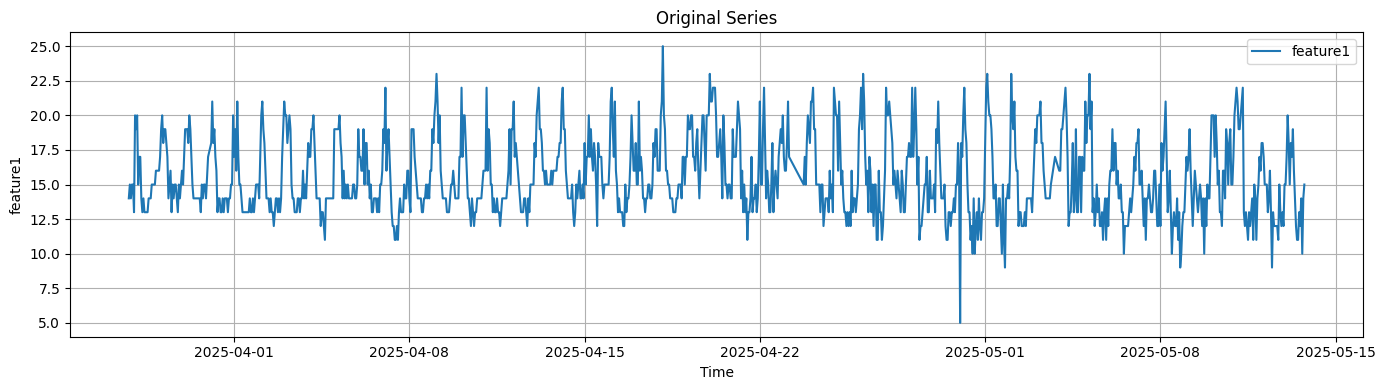

In [6]:
import pandas as pd

url = "https://raw.githubusercontent.com/GeneSUN/time-series-analysis-toolkit/main/Data/df_cap_hour_pd.csv"
df_cap_hour_pd = pd.read_csv(url).rename(columns={'avg_4gsnr': 'feature1', 'avg_5gsnr': 'feature2'})\
                  .drop( columns =["feature2"]  )

base_inspector = BaseTimeSeriesInspector(df_cap_hour_pd, datetime_col='hour', value_col='feature1')
print("\n1. 📈 Plot Original Time Series")
base_inspector.plot_series()

In [7]:
df_cap_hour_pd.head()

,sn,hour,feature1
0,ABB30701372,2025-03-27T19:00:00.000-04:00,14.0
1,ABB30701372,2025-03-27T20:00:00.000-04:00,15.0
2,ABB30701372,2025-03-27T21:00:00.000-04:00,14.0
3,ABB30701372,2025-03-27T22:00:00.000-04:00,15.0
4,ABB30701372,2025-03-27T23:00:00.000-04:00,15.0


# 1.Lags or backshift

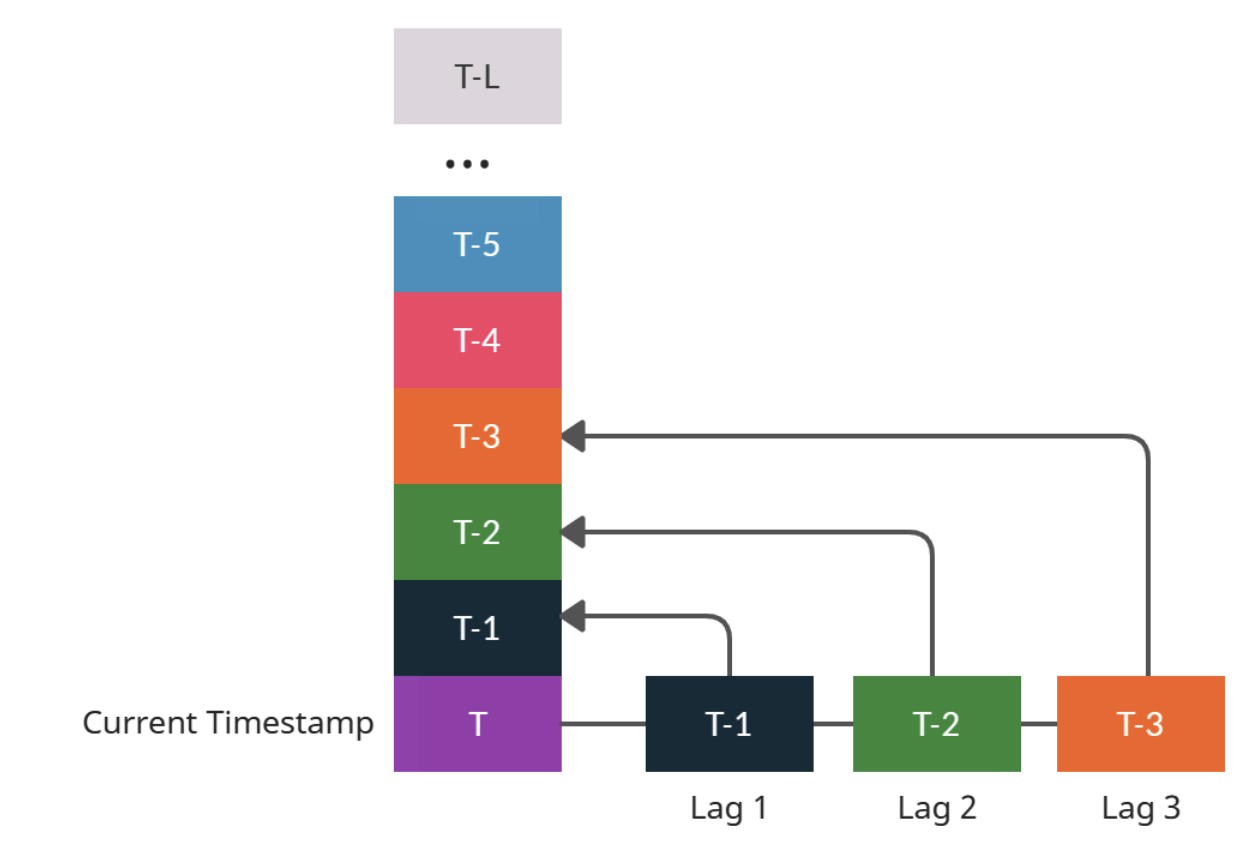

In [8]:
df_lags, new_features = create_lag_features(df_cap_hour_pd, lags=[i for i in range(1,10)], target_col='feature1')
df_lags.head(3)

,sn,hour,feature1,feature1_lag_1,feature1_lag_2,feature1_lag_3,feature1_lag_4,feature1_lag_5,feature1_lag_6,feature1_lag_7,feature1_lag_8,feature1_lag_9
0,ABB30701372,2025-03-28T04:00:00.000-04:00,15.0,20.0,19.0,20.0,13.0,15.0,15.0,14.0,15.0,14.0
1,ABB30701372,2025-03-28T05:00:00.000-04:00,17.0,15.0,20.0,19.0,20.0,13.0,15.0,15.0,14.0,15.0
2,ABB30701372,2025-03-28T06:00:00.000-04:00,17.0,17.0,15.0,20.0,19.0,20.0,13.0,15.0,15.0,14.0


In [9]:
#@title Interactive plot of Lags
import plotly.graph_objects as go
from plotly.subplots import make_subplots



# --- Create subplots ---
fig = make_subplots(
    rows=5, cols=1, shared_xaxes=True,
    subplot_titles=["Original Series (first 20 rows)"] +
                   [f"Lag features leading to row {i}" for i in range(4)]
)

# 1. Original series (first 20 rows)
fig.add_trace(
    go.Scatter(
        x=list(range(1, 21)),
        y=df_cap_hour_pd['feature1'].iloc[:20],
        mode="lines+markers",
        name="feature1",
        text=[f"feature1[{i+1}] = {val}" for i, val in enumerate(df_cap_hour_pd['feature1'].iloc[:20])],
        hoverinfo="text"
    ),
    row=1, col=1
)

# 2–5. Lagged features + target as one connected sequence
for i in range(4):
    start = i
    end = i + 9
    x_vals = list(range(start+1, end+2))  # include target at end

    # lag values (lag_9 … lag_1)
    lag_vals = df_lags[new_features].iloc[i].values[::-1]
    target_val = df_lags['feature1'].iloc[i]

    # combine lags + target
    values = list(lag_vals) + [target_val]
    labels = [f"feature1_lag_{lag}" for lag in range(9, 0, -1)] + ["feature1"]

    hover_texts = [f"{label} (row {i}): {val}" for label, val in zip(labels, values)]

    fig.add_trace(
        go.Scatter(
            x=x_vals,
            y=values,
            mode="lines+markers",
            name=f"Row {i} sequence",
            text=hover_texts,
            hoverinfo="text",
            marker=dict(
                color=["blue"]*9 + ["red"],   # blue for lags, red for target
                symbol=["circle"]*9 + ["star"],  # circle for lags, star for target
                size=10
            ),
            line=dict(color="blue", dash="solid")
        ),
        row=i+2, col=1
    )

# Layout
fig.update_layout(
    height=1200,
    title="Original Series and Lagged Sequences with Target Highlighted",
    showlegend=False
)

fig.show()


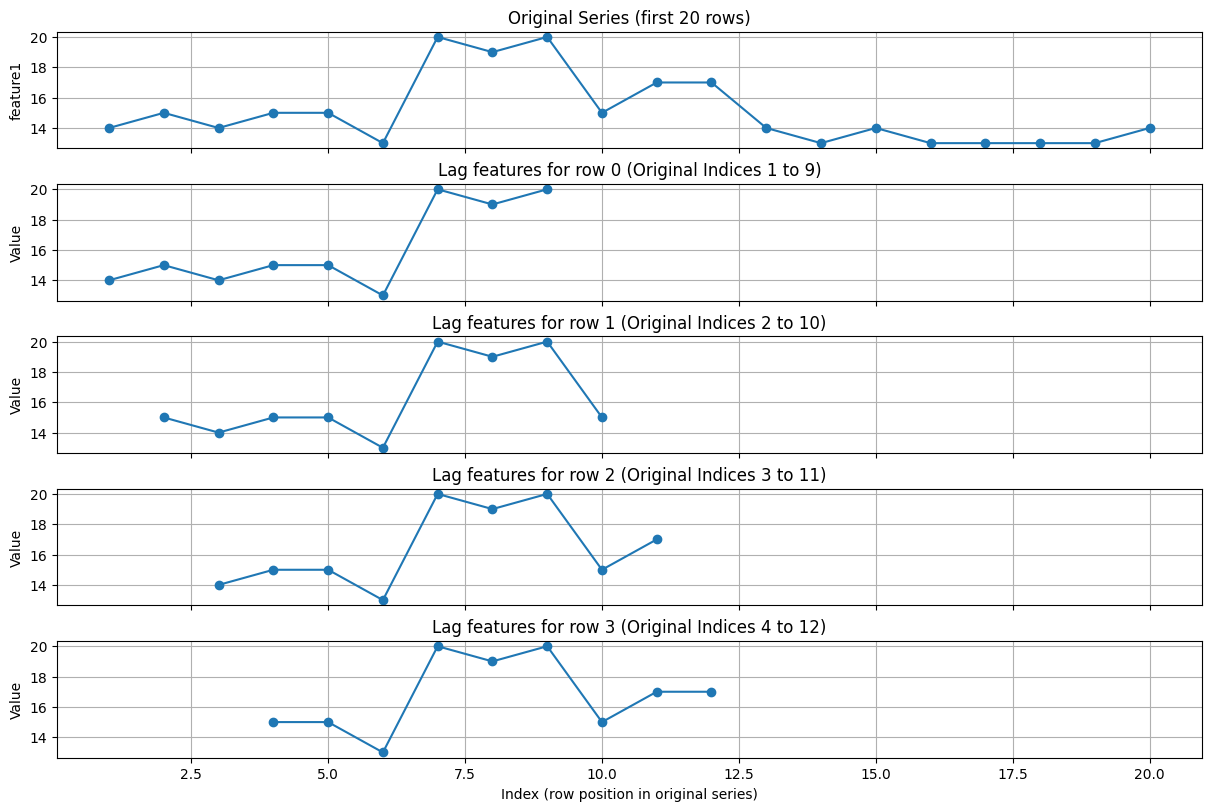

In [10]:
#@title plot of Lags
import matplotlib.pyplot as plt

# Run lag feature creation
df_lags, new_features = create_lag_features(
    df_cap_hour_pd,
    lags=[i for i in range(1, 10)],
    target_col='feature1'
)

# --- Create subplots ---
fig, axes = plt.subplots(5, 1, figsize=(12, 8), constrained_layout=True, sharex=True)

# 1. Plot the first 20 rows of the original series
axes[0].plot(range(1, 21), df_cap_hour_pd['feature1'].iloc[:20], marker='o')
axes[0].set_title("Original Series (first 20 rows)")
axes[0].set_ylabel("feature1")
axes[0].grid(True)

# 2–5. Plot the first 4 rows of lagged features as aligned slices
for i in range(4):
    # current observation is at position (i+9) because of 9 lags
    start = i
    end = i + 9
    # x_vals should represent the original indices corresponding to the lagged values
    # For row i of df_result, the lags correspond to original indices i to i + 8
    x_vals = list(range(start + 1, end + 1)) # Corrected range

    row_values = df_lags[new_features].iloc[i].values[::-1]  # lag_9 … lag_1
    axes[i+1].plot(x_vals, row_values, marker='o')

    axes[i+1].set_title(f"Lag features for row {i} (Original Indices {start+1} to {end})") # Update title for clarity
    axes[i+1].set_ylabel("Value")
    axes[i+1].grid(True)

# Common x-axis
axes[-1].set_xlabel("Index (row position in original series)")
plt.show()

# 2.Rolling window aggregations

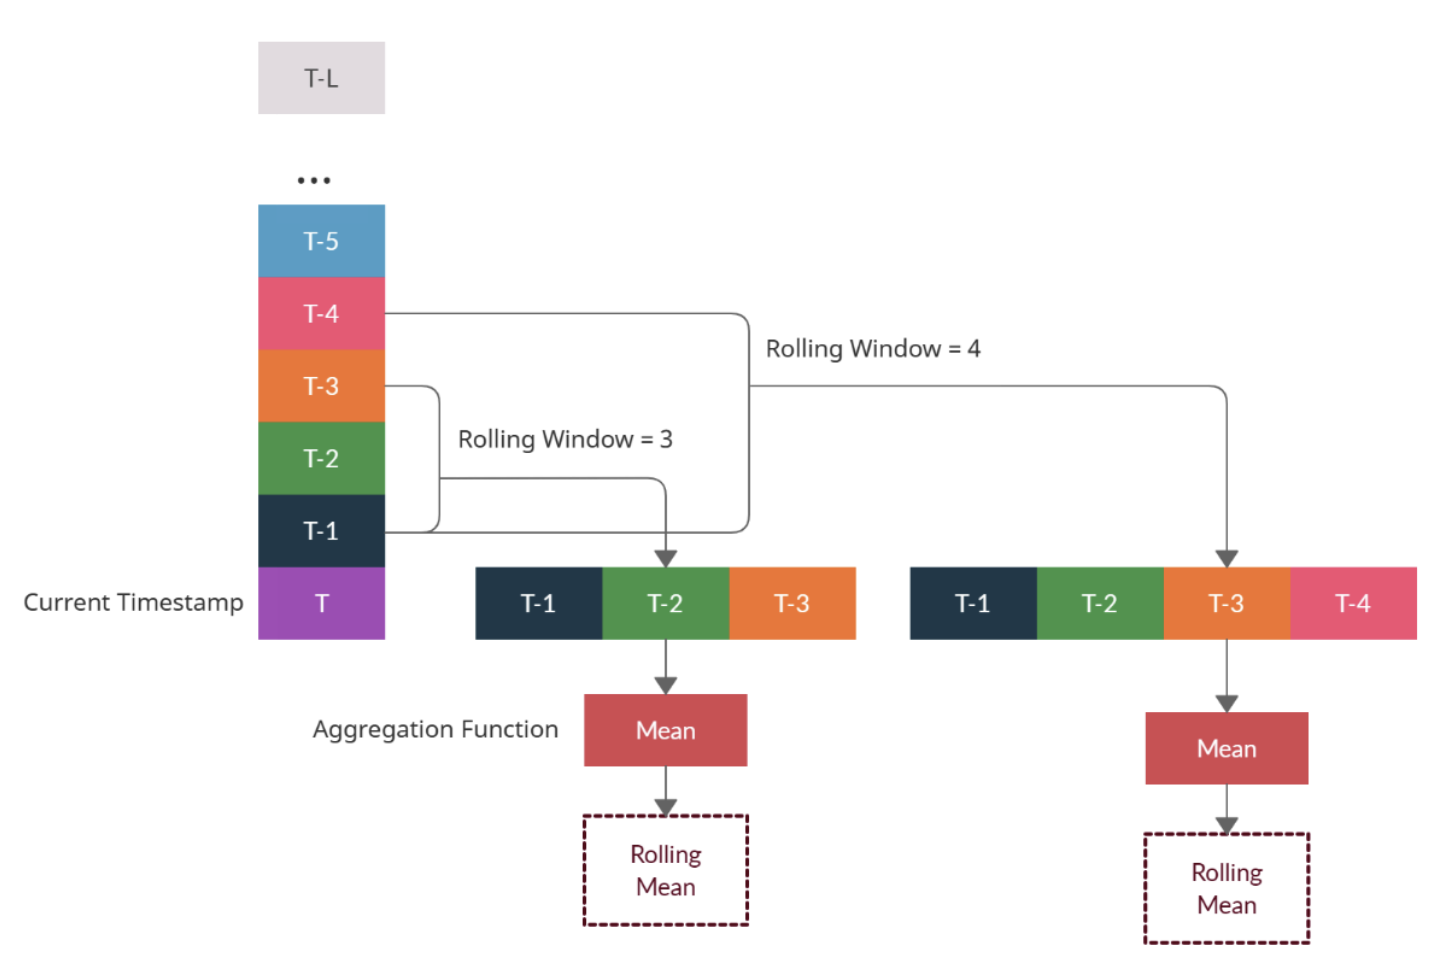


In [13]:
#@title Plot rolling features-Mean
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_rolling_features(
    df: pd.DataFrame,
    target_col: str,
    new_features: List[str],
    n_points: int = 50
):
    """
    Interactive visualization of rolling features vs original series.

    Args:
        df (pd.DataFrame): DataFrame with original + rolling features.
        target_col (str): Name of the original column.
        new_features (List[str]): List of rolling features to plot.
        n_points (int, optional): Number of points from the start to display. Defaults to 50.
    """
    # Limit data
    df_plot = df[[target_col] + new_features].iloc[:n_points]

    # Create subplots: one row per feature (+1 for original)
    fig = make_subplots(
        rows=len(new_features)+1, cols=1, shared_xaxes=True,
        subplot_titles=[f"Original Series ({target_col})"] + new_features
    )

    # 1. Original series
    fig.add_trace(
        go.Scatter(
            x=df_plot.index,
            y=df_plot[target_col],
            mode="lines+markers",
            name=target_col,
            text=[f"{target_col}[{i}] = {val}" for i, val in zip(df_plot.index, df_plot[target_col])],
            hoverinfo="text"
        ),
        row=1, col=1
    )

    # 2. Rolling features
    for i, feat in enumerate(new_features, start=2):
        fig.add_trace(
            go.Scatter(
                x=df_plot.index,
                y=df_plot[feat],
                mode="lines+markers",
                name=feat,
                text=[f"{feat}[{i}] = {val}" for i, val in zip(df_plot.index, df_plot[feat])],
                hoverinfo="text"
            ),
            row=i, col=1
        )

    # Layout
    fig.update_layout(
        height=300*(len(new_features)+1),
        title=f"Rolling Features Visualization for {target_col}",
        showlegend=False
    )
    fig.show()




In [28]:
df_roll_means, roll_feats = create_rolling_features(
    df_cap_hour_pd,
    windows=[3, 5, 10],
    target_col="feature1",
    agg_funcs=["mean"]
)
df_roll_means.dropna().head(3)

,sn,hour,feature1,feature1_rolling_3_mean,feature1_rolling_5_mean,feature1_rolling_10_mean
10,ABB30701372,2025-03-28T05:00:00.000-04:00,17.0,18.000000,17.4,16.0
11,ABB30701372,2025-03-28T06:00:00.000-04:00,17.0,17.333333,18.2,16.3
12,ABB30701372,2025-03-28T07:00:00.000-04:00,14.0,16.333333,17.6,16.5


In [14]:
# ----------------------------------------------------------------------------


# Plot
plot_rolling_features(df_roll_means, "feature1", roll_feats, n_points=50)

In [15]:
#@title Plot rolling features-Std
df_roll_std, roll_feats = create_rolling_features(
    df_cap_hour_pd,
    windows=[3, 5, 10],
    target_col="feature1",
    agg_funcs=["std"]
)

# Plot
plot_rolling_features(df_roll_std, "feature1", roll_feats, n_points=50)


# 3.Seasonal rolling window aggregations

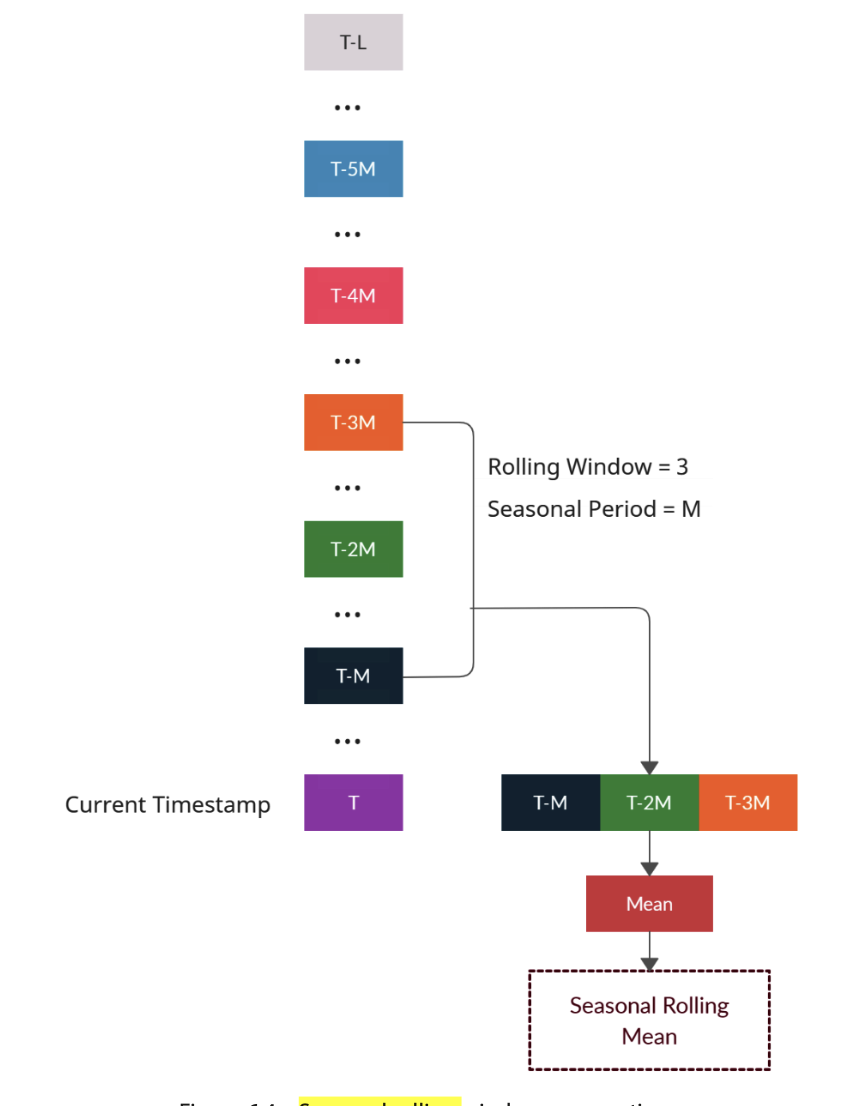

In [17]:
# Create seasonal rolling features
df_season, season_feats = create_seasonal_rolling_features(
    df_cap_hour_pd,
    seasonal_periods=[24],   # weekly, monthly
    windows=[4],             # rolling over 2, 3 past seasonal cycles
    target_col="feature1",
    agg_funcs=["mean", "std"]
)

df_season.tail(10)

,sn,hour,feature1,feature1_24_seasonal_rolling_4_mean,feature1_24_seasonal_rolling_4_std
1092,ABB30701372,2025-05-13T09:00:00.000-04:00,14.0,14.00,2.309401
1093,ABB30701372,2025-05-13T10:00:00.000-04:00,12.0,13.25,0.500000
1094,ABB30701372,2025-05-13T11:00:00.000-04:00,11.0,12.50,2.886751
1095,ABB30701372,2025-05-13T12:00:00.000-04:00,11.0,12.75,1.707825
1096,ABB30701372,2025-05-13T13:00:00.000-04:00,13.0,13.75,1.707825
1097,ABB30701372,2025-05-13T14:00:00.000-04:00,12.0,13.25,1.892969
1098,ABB30701372,2025-05-13T15:00:00.000-04:00,14.0,13.50,1.290994
1099,ABB30701372,2025-05-13T16:00:00.000-04:00,10.0,14.75,2.986079
1100,ABB30701372,2025-05-13T17:00:00.000-04:00,14.0,13.00,3.366502
1101,ABB30701372,2025-05-13T18:00:00.000-04:00,15.0,14.75,0.500000


In [18]:
#@title plot_seasonal_rolling_features
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from typing import List, Optional
import pandas as pd

def plot_seasonal_rolling_features(
    df: pd.DataFrame,
    target_col: str,
    new_features: List[str],
    x_col: Optional[str] = None,
    n_points: Optional[int] = None
):
    """
    Interactive visualization of seasonal rolling features vs original series.

    - Each subplot is separate: one for the original series, one for each feature.
    - X-axis can be a dedicated column (e.g., time) or fallback to index.
    - Default n_points is the full length of the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame with original + seasonal rolling features.
        target_col (str): Name of the original column.
        new_features (List[str]): List of seasonal rolling features to plot.
        x_col (str, optional): Column to use as x-axis. Defaults to index.
        n_points (int, optional): Number of points to display. Defaults to len(df).
    """
    if n_points is None:
        n_points = len(df)

    # Limit data
    cols_needed = [target_col] + new_features + ([x_col] if x_col else [])
    df_plot = df[cols_needed].iloc[:n_points]

    # Define x-axis
    x = df_plot[x_col] if x_col else df_plot.index

    # Subplot structure: 1 for original + one for each feature
    total_rows = 1 + len(new_features)
    titles = [f"Original Series ({target_col})"] + new_features

    fig = make_subplots(
        rows=total_rows, cols=1, shared_xaxes=True,
        subplot_titles=titles
    )

    row = 1

    # 1. Original series
    fig.add_trace(
        go.Scatter(
            x=x, y=df_plot[target_col],
            mode="lines+markers",
            name=target_col,
            line=dict(color="black", width=2),
            text=[f"{target_col}[{i}] = {val}" for i, val in zip(x, df_plot[target_col])],
            hoverinfo="text"
        ),
        row=row, col=1
    )
    row += 1

    # 2. Each feature in its own subplot
    for feat in new_features:
        fig.add_trace(
            go.Scatter(
                x=x, y=df_plot[feat],
                mode="lines+markers",
                name=feat,
                text=[f"{feat}[{i}] = {val}" for i, val in zip(x, df_plot[feat])],
                hoverinfo="text"
            ),
            row=row, col=1
        )
        row += 1

    # Layout
    fig.update_layout(
        height=300 * total_rows,
        title=f"Seasonal Rolling Features Visualization for {target_col}",
        showlegend=True
    )
    fig.show()

plot_seasonal_rolling_features(
    df_season,
    target_col="feature1",
    new_features=season_feats,
    x_col="hour"  # Use time column for x-axis if available
)


# 4.Exponentially weighted moving averages (EWMA)

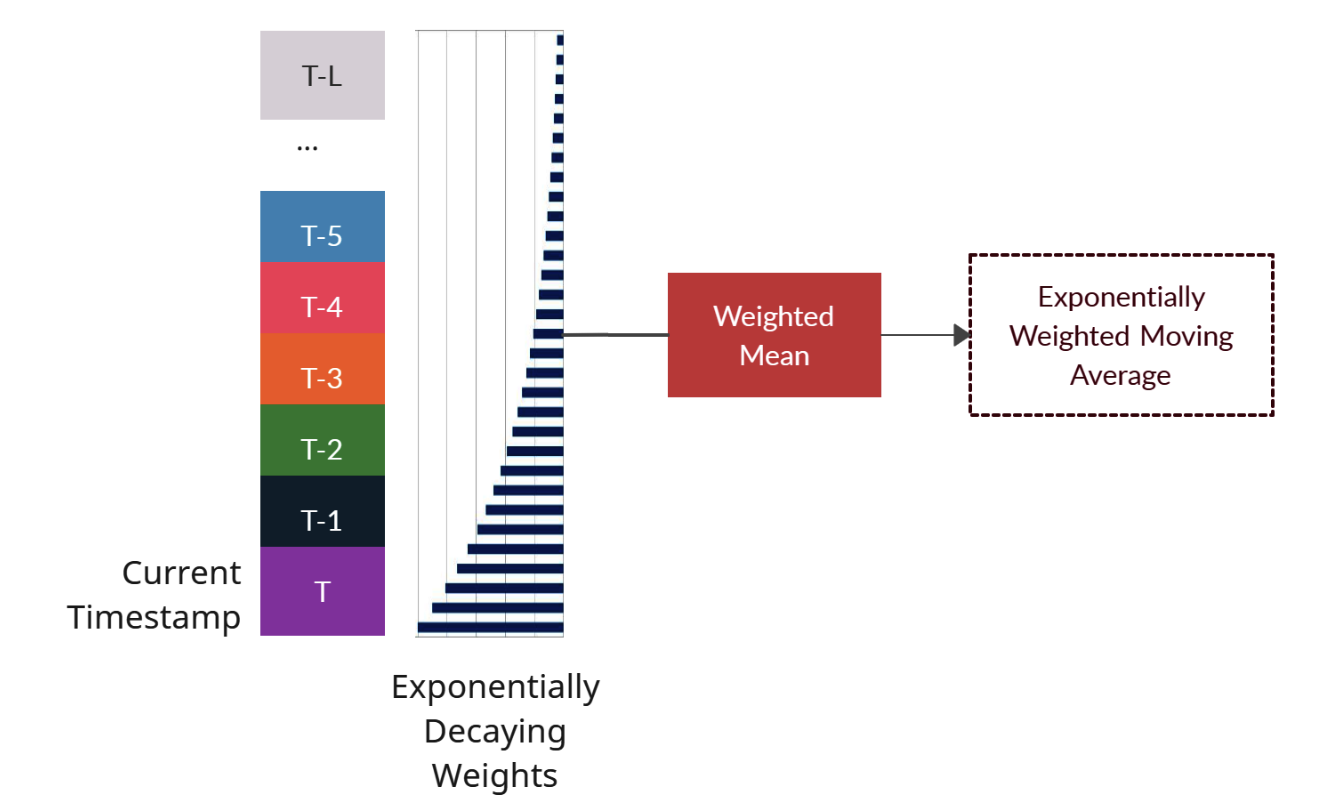


In [19]:
# Create EWMA features
df_ewma, ewma_feats = create_ewma_features(
    df=df_cap_hour_pd,         # Provide the DataFrame
    target_col='feature1',    # Provide the target column
    spans=[3, 7, 14]          # Provide a list of spans (or alphas)
)

# Display the head of the DataFrame with new EWMA features
print("Head of DataFrame with new EWMA features:")
display(df_ewma.head())

Head of DataFrame with new EWMA features:


,sn,hour,feature1,feature1_ewma_span_3,feature1_ewma_span_7,feature1_ewma_span_14
0,ABB30701372,2025-03-27T19:00:00.000-04:00,14.0,NaN,NaN,NaN
1,ABB30701372,2025-03-27T20:00:00.000-04:00,15.0,14.000,14.000000,14.000000
2,ABB30701372,2025-03-27T21:00:00.000-04:00,14.0,14.500,14.250000,14.133333
3,ABB30701372,2025-03-27T22:00:00.000-04:00,15.0,14.250,14.187500,14.115556
4,ABB30701372,2025-03-27T23:00:00.000-04:00,15.0,14.625,14.390625,14.233481


# Join all Features Engineering

In [21]:
#@title Final result

df_cap_hour_pd_indexed = df_cap_hour_pd.set_index("hour")

# Original columns to keep
original_cols = ["sn", "feature1"]

# Map of feature DataFrames
feature_dfs = {
    "lags": df_lags,
    "roll_mean": df_roll_means,
    "roll_std": df_roll_std,
    "season": df_season,
    "ewma": df_ewma,
}

# Start merged DataFrame with original columns
df_merged = df_cap_hour_pd_indexed[original_cols].copy()

# Collect feature column names for reference
feature_columns = {}

# Process each feature DataFrame
for name, feat_df in feature_dfs.items():
    feat_indexed = feat_df.set_index("hour")
    new_cols = [col for col in feat_indexed.columns if col not in original_cols]
    feature_columns[name] = new_cols
    df_merged = df_merged.merge(
        feat_indexed[new_cols],
        left_index=True, right_index=True,
        how="outer"
    )

# Drop unwanted column and reset index
df_merged = df_merged.dropna().reset_index().reset_index()

# Show results
print("Head of merged DataFrame:")
display(df_merged.head())

print("\nInfo of merged DataFrame:")
df_merged.info()


Head of merged DataFrame:


,index,hour,sn,feature1,feature1_lag_1,feature1_lag_2,feature1_lag_3,feature1_lag_4,feature1_lag_5,feature1_lag_6,...,feature1_rolling_5_mean,feature1_rolling_10_mean,feature1_rolling_3_std,feature1_rolling_5_std,feature1_rolling_10_std,feature1_24_seasonal_rolling_4_mean,feature1_24_seasonal_rolling_4_std,feature1_ewma_span_3,feature1_ewma_span_7,feature1_ewma_span_14
0,0,2025-03-31T23:00:00.000-04:00,ABB30701372,20.0,15.0,15.0,14.0,14.0,13.0,14.0,...,14.2,14.0,0.577350,0.836660,0.666667,14.75,0.500000,14.716123,14.346672,14.369717
1,1,2025-04-01T00:00:00.000-04:00,ABB30701372,17.0,20.0,15.0,15.0,14.0,14.0,13.0,...,15.6,14.6,2.886751,2.509980,2.011080,14.50,0.577350,17.358062,15.760004,15.120421
2,2,2025-04-01T01:00:00.000-04:00,ABB30701372,19.0,17.0,20.0,15.0,15.0,14.0,14.0,...,16.2,15.0,2.516611,2.387467,2.054805,15.50,1.290994,17.179031,16.070003,15.371032
3,3,2025-04-01T02:00:00.000-04:00,ABB30701372,16.0,19.0,17.0,20.0,15.0,15.0,14.0,...,17.2,15.5,1.527525,2.280351,2.368778,16.25,1.258306,18.089515,16.802502,15.854894
4,4,2025-04-01T03:00:00.000-04:00,ABB30701372,21.0,16.0,19.0,17.0,20.0,15.0,15.0,...,17.4,15.7,1.527525,2.073644,2.311805,16.75,2.872281,17.044758,16.601877,15.874242



Info of merged DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   index                                1006 non-null   int64  
 1   hour                                 1006 non-null   object 
 2   sn                                   1006 non-null   object 
 3   feature1                             1006 non-null   float64
 4   feature1_lag_1                       1006 non-null   float64
 5   feature1_lag_2                       1006 non-null   float64
 6   feature1_lag_3                       1006 non-null   float64
 7   feature1_lag_4                       1006 non-null   float64
 8   feature1_lag_5                       1006 non-null   float64
 9   feature1_lag_6                       1006 non-null   float64
 10  feature1_lag_7                       1006 non-null   float64
 11  fea